In [1]:
## Establish connection to Orthanc server
from utils import queryStudies
from pyorthanc import Orthanc, RemoteModality
orthanc = Orthanc('http://orthanc:8042')
orthanc.setup_credentials('user', 'password')
print(orthanc.get_modalities())
PACS = "FMC"
remote_modality = RemoteModality(orthanc, PACS)
print(remote_modality.echo())

['DataCentre', 'FMC', 'sample']
True


In [14]:
# Extract series corresponding to the studies
from utils import getSeriesfromStudyDF, checkpointer
from utils import get_subgroup
import itertools
import pandas as pd
import json

target_studies = pd.read_json('../data_to_get/all_chest_studies.json')

# Create extraction function which taxes a series as input
extract_fn = lambda x: getSeriesfromStudyDF(orthanc, PACS, x)
extract_fn.__name__ = getSeriesfromStudyDF.__name__
# Define sizes for splitting checkpoints and save points.
# The function operates on batch_size elements with a checkpointer, and saves
#  after group_size elements have been processed.
group_size = 100000
batch_size = 10000


# Initialise json file to hold series data
save_file = "../data_to_get/all_series_save.json"
## WARNING: If you already have data saved in the above path, don't run the next two lines or your data will be overwritten.
with open(save_file, 'w') as f:
    f.write('[') # Start list

# Extract data and store in rows of json file
for target_subgroup in get_subgroup(target_studies, 100000):
    series_sublist = checkpointer(extract_fn, target_subgroup, batch_size)
    # Check to see how much useful data there is in sublist.
    # Sometimes, there is less data extracted than what we'd expect.
    unpacked_series = list(itertools.chain(*series_sublist))
    reduced_unpacked_series = [x for x in unpacked_series if x != []]
    print("Extracted subseries contains {} elements.".format(
        len(reduced_unpacked_series)
    ))
    print("Compare to input series with {} elements".format(
        len(target_subgroup)
    ))
    # Append data
    with open(save_file, 'a') as f:
        json.dump(series_sublist, f)
        f.write(',\n') # Continue to next element of list

# Close json string
with open(save_file, 'a') as f:
    f.write('[]\n]') # Append empty element, then close list

# Read all results from file and summarise number of elements
series_list = []
with open(save_file) as f:
    series_list = json.load(f)
series_list = list(itertools.chain(*series_list))
print("Completed data extraction.")
print("Extracted total of {} elements".format(len(series_list)))


Running function: 'getSeriesfromStudyDF' in checkpointer
Elements in sequence: 100000
Number of iterations required: 10

Starting at checkpoint 0
10000 studies found! Retrieving Series details...


 15%|█▌        | 1516/10000 [01:50<13:17, 10.64it/s]

In [1]:
from utils import serieslist2df
import itertools
import json

# Get series data from save file
series_list = []
with open('../data_to_get/all_series_save.json') as f:
    series_list = json.load(f)
series_list = list(itertools.chain(*series_list))

# Convert to dataframe. This is a little bit of Black Magic.
series_df = serieslist2df(series_list)

# Remove NA and duplicates 
series_df.dropna(inplace=True)
series_df.drop_duplicates('SeriesInstanceUID', inplace=True)

# Make strings lowercase
series_df['SeriesDescription'] = series_df['SeriesDescription'].str.lower()

# Filter by modality.
# SR are reports, OT are others (sometimes xray, cts, reports, unknowns)
# CT, CR, DX are all radiographic outputs
keep_modalities = ['CT', 'CR', 'DX', 'OT', 'SR']
series_df = series_df[series_df['Modality'].isin(keep_modalities)]


# Display series data
series_df

,AccessionNumber,IssuerOfPatientID,Modality,NumberOfSeriesRelatedInstances,PatientID,QueryRetrieveLevel,RetrieveAETitle,SeriesDescription,SeriesInstanceUID,SpecificCharacterSet,StudyInstanceUID,TypeOfPatientID
0,00073311CXR,FMC,CR,2,005826530,SERIES,433wfmFIR,chest,1.3.6.1.4.1.23849.1900913979.1208.163339014188...,ISO_IR 100,1.2.124.113532.10.18.103.27.20080219.102215.74...,TEXT
1,01004207CXR,FMC,CR,2,003623270,SERIES,433wfmFIR,chest,1.3.6.1.4.1.23849.3570459044.11.16342420099493...,ISO_IR 100,1.2.124.113532.10.18.103.27.20101101.93612.205...,TEXT
2,01049379CXR,FMC,CR,2,005826530,SERIES,433wfmFIR,chest,1.3.6.1.4.1.23849.2301715136.1208.163339014311...,ISO_IR 100,1.2.124.113532.10.18.103.27.20080219.102438.74...,TEXT
3,02001727CXR,FMC,CR,2,005444487,SERIES,433wfmFIR,"chest, abd",1.3.6.1.4.1.23849.3944441086.11.16359743003728...,ISO_IR 100,1.3.6.1.4.1.23849.2503979210.11.16359743003718...,TEXT
4,02030123CXR,FMC,CR,2,004588497,SERIES,433wfmFIR,chest,1.3.6.1.4.1.23849.3167668804.1344.163343501681...,ISO_IR 100,1.2.124.113532.10.18.103.27.20080411.84803.819312,TEXT
...,...,...,...,...,...,...,...,...,...,...,...,...
2043468,5012750408,FMC,CT,49,009246234,SERIES,433wfmFIR,mediastinal mediastinal plain/coronal 5.000 c...,1.2.392.200036.9116.2.6.1.3268.2051117328.1640...,ISO_IR 100,1.2.840.113564.9.1.2815321601.78.2.5012750408,TEXT
2043469,5012750408,FMC,CT,344,009246234,SERIES,433wfmFIR,lung lung plain 1.0 lung,1.2.392.200036.9116.2.6.1.3268.2051117328.1640...,ISO_IR 100,1.2.840.113564.9.1.2815321601.78.2.5012750408,TEXT
2043470,5012750408,FMC,CT,55,009246234,SERIES,433wfmFIR,lung lung plain/axial 5.000 axial,1.2.392.200036.9116.2.6.1.3268.2051117328.1640...,ISO_IR 100,1.2.840.113564.9.1.2815321601.78.2.5012750408,TEXT
2043471,5012750408,FMC,CT,683,009246234,SERIES,433wfmFIR,soft neck plain 0.5 soft,1.2.392.200036.9116.2.6.1.3268.2051117328.1640...,ISO_IR 100,1.2.840.113564.9.1.2815321601.78.2.5012750408,TEXT


In [4]:
print(series_df['Modality'].value_counts())
print(len(series_df))

CR    718681
CT    501897
DX    238878
SR    140661
OT    136934
Name: Modality, dtype: int64
1737051


chest                   301820
ap                      281588
xr chest                 85874
lateral l                75263
pa cxr                   67442
chest pa                 54104
chest left lat           52630
pa                       37081
lateral                  29495
w chest pa               16766
w chest lat              14905
pa expiration             5040
x chest ap                3033
chest ap                  2371
ap (skyflow)              1741
cxr lat                   1723
chest pa exp              1610
cxr pa landscape           930
cxr pa portrait            888
chest pa insp              530
w chest lateral            408
lateral r                  265
chest right lat            142
ap supine                  138
ap (in-bucky)              130
w chest pa portrait        112
lateral chest              112
pa chest                   101
chest lat                   98
w chest pa landscape        73
w chest ap                  66
lpo                         65
rpo     

<AxesSubplot:>

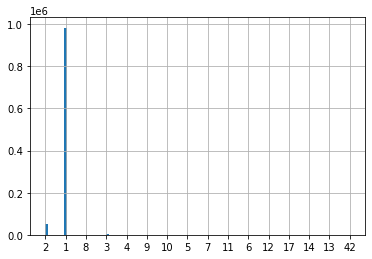

In [10]:
## FILTERING CXR
# print(series_df['SeriesDescription'].str.contains('ct'))
cxr_series_df = series_df[
    ~series_df['Modality'].isin(['CT', 'SR'])
    & ~series_df['SeriesDescription'].str.contains('ct')
]


# Filter number of times study description is used.
minimum_number_of_occurrences = 10
cxr_series_df = cxr_series_df.groupby('SeriesDescription').filter(
    lambda x: len(x)>minimum_number_of_occurrences)

## Filter by series description
## Comment out lines in this section to see all study descriptions, use this to base futher filtering on.
# keep_descriptions = ['xr', 'chest', 'lung']
remove_descriptions = ['form', 'order', 'worksheet', 'abdomen', 'questionnaire', 'document', 'survey', 'pelvis', 'spine', 'ribs', 'skull', 'implant', 'humerus', 'others', 'hip', 'cervi', 'decub', 'key image']
# keep_string = "|".join(keep_descriptions)
remove_string = "|".join(remove_descriptions)
cxr_series_df = cxr_series_df[
    ~cxr_series_df['SeriesDescription'].str.contains(remove_string)
]


print(cxr_series_df['SeriesDescription'].value_counts()[:50])

/tmp/ipykernel_4399/2156047150.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ct_series_df['NumberOfSeriesRelatedInstances'] = ct_series_df['NumberOfSeriesRelatedInstances'].apply(pd.to_numeric)


lung thins, idose (3)               10745
lung thins                           7957
chest thins                          3625
thins                                3218
lung lung 1.0 c+                     1504
lung lung                            1174
thin slices of series 202            1012
lung  lung c+ 1.0 lung                925
thin slices of series 402             681
lung c+  lung                         438
chest plain thin                      423
med thin, idose (3)                   415
thin slices of series 502             390
hr lung insp thi                      378
thin slices of series 302             367
hr lung thins, idose (3)              367
med inspir thins, idose (3)           364
thin slices of series 205             351
hr chest insp                         341
ctpa thins, idose (3)                 326
hrct thins, idose (3)                 325
lungthins, idose (3)                  323
cap plain thins                       309
thin slices of series 802, 803    

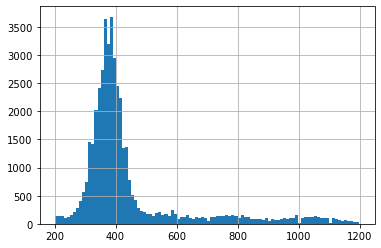

In [21]:
## FILTERING CT
import pandas as pd

ct_series_df = series_df[
    series_df['Modality'].isin(['CT'])
    | series_df['SeriesDescription'].str.contains('ct')
]

#
ct_series_df['NumberOfSeriesRelatedInstances'] = ct_series_df['NumberOfSeriesRelatedInstances'].apply(pd.to_numeric)

# Display number of instances before filtering
# ct_series_df['NumberOfSeriesRelatedInstances'].hist(bins=100)
thins_min_thresh = 200
thins_max_thresh = 1200
# Comment out if you don't want to filter by number of thins.
ct_series_df = ct_series_df[
    ct_series_df['NumberOfSeriesRelatedInstances']>thins_min_thresh
]
ct_series_df = ct_series_df[
    ct_series_df['NumberOfSeriesRelatedInstances']<thins_max_thresh
]

# Filter by series name
# Comment out to see all study descriptions to select appropriate filters.
remove_descriptions = ['medias', 'body', 'brain', 'venous', 'bone', 'abdomen', 'skull', 'neck', 'bone', 'pv ', 'csp', 'soft', 'cta', ]
remove_string = "|".join(remove_descriptions)
ct_series_df = ct_series_df[
    ~ct_series_df['SeriesDescription'].str.contains(remove_string)
]


ct_series_df['NumberOfSeriesRelatedInstances'].hist(bins=100)
print(ct_series_df['SeriesDescription'].value_counts()[:50])
print(len(ct_series_df))
# ct_series_df

In [22]:
# SR filtering
sr_series_df = series_df[
    series_df['Modality'].isin(['SR'])
]

print(sr_series_df['SeriesDescription'].value_counts())

# sr_series_df
# print(sr_series_df[sr_series_df['SeriesDescription'].str.contains('pacs')])

carestream pacs reports                           128215
radiation dose information                         12331
fuji basic text sr for hl7 radiological report        54
dose report                                           42
dose record                                            9
examination report                                     6
exam protocol sr                                       2
phoenixzipreport                                       2
Name: SeriesDescription, dtype: int64


In [23]:
## Save CXR, CT, SR dataframes
necessary_columns = ['AccessionNumber', 'SeriesInstanceUID']

cxr_series_df[necessary_columns].to_json('../data_to_get/cxr_series.json')
cxr_series_df[necessary_columns].to_csv('../data_to_get/cxr_series.csv')
ct_series_df[necessary_columns].to_json('../data_to_get/ct_series.json')
ct_series_df[necessary_columns].to_csv('../data_to_get/ct_series.csv')
sr_series_df[necessary_columns].to_json('../data_to_get/sr_series.json')
sr_series_df[necessary_columns].to_csv('../data_to_get/sr_series.csv')